# Quick and Dirty attempt to train a model

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split
import time

%matplotlib inline

TODO:  
* Add a verbose boolean to reduce all the extra things I am printing out to understand the process 
* maybe removing horizontal flip as well?

In [2]:
## bs = 64
bs = 32  ## for out of memory

In [3]:
data_fp = Path('./data/')
data_train = data_fp/'train'; data_train

WindowsPath('data/train')

In [4]:
# look at folder tree
!tree {data_fp} /a

Folder PATH listing for volume Windows
Volume serial number is 0E7B-C763
C:\USERS\BOKI\DESKTOP\PROJECTS\KAGGLE\HUMPBACK_KAGGLE\DATA
+---models
+---test
\---train
    \---models


# Looking at the data

In [5]:
labels = pd.read_csv(data_fp/'train.csv')
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


## Split data into training and validation set
Because the data is extremely unbalance where it contains classes with only one sample, we cannot use a random sampling method.   
Fastai will get an error when there is a class in the validation set and not in training set. [link](https://github.com/fastai/fastai/issues/1273)

In addition, we cannot use StratifiedShuffleSplit because the minimum number of groups for any class cannot be less than 2.   
Therefore, we will need to duplicate images for this to work. Instead, we will manually create a train and validation split. 

In [6]:
# ## Save code just in case for future use
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# ## split is decided by the Id column
# for train_index, val_index in sss.split(labels.index.values, labels.Id):
#     train_idx, val_idx = train_index, val_index  

In [7]:
class_counts = labels.Id.value_counts(sort=True, ascending=True)
print(f'The number of images: {class_counts.sum():,}')
print('{}'.format('='*20))
print(f'Number of classes with only one image: {sum(class_counts == 1):,}')
print(f'Percentage of classes with one image: {sum(class_counts == 1)/len(labels.Id.unique()):.0%}')
print('{}'.format('='*20))
print(f'Number of new_whate image: {class_counts["new_whale"].sum():,}')
print(f'Percentage of images are new_whale: {class_counts["new_whale"]/class_counts.sum()*100:0.0f}%')

The number of images: 25,361
Number of classes with only one image: 2,073
Percentage of classes with one image: 41%
Number of new_whate image: 9,664
Percentage of images are new_whale: 38%


In [8]:
class_counts[::-1][:5]  # top five most common class

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

### Stratified Split
Split the data such that classes with only 1 sample will go into training set and classes with 2+ will split randomly with ~20% into validation set. 

In [9]:
start_time = time.time()
## stratify sampling that can handle 
train_idx, val_idx = pd.Series(), pd.Series()
for name, group in labels.reset_index()[['index', 'Id']].groupby(['Id']):
    ## if a class only have 1 sample, just return that one
    if group.shape[0] == 1:
        train, val = group['index'], []
    ## split each group randomly and obtain their index
    else:
        train, val = train_test_split(group['index'], test_size=0.2, random_state=None)
    train_idx = train_idx.append(train)
    val_idx = val_idx.append(val)
    
print(f'It took {int(time.time() - start_time)} seconds')

It took 4 seconds


In [10]:
train_idx.head()

5482      5482
19415    19415
2451      2451
23594    23594
22276    22276
dtype: int64

In [11]:
## assess that the number of class are all accounted for in the training indexing
assert len(labels.loc[train_idx, 'Id'].unique()) == len(labels.Id.unique())
print('Number of class {}: {}'.format(len(labels.loc[train_idx, 'Id'].unique()), len(labels['Id'].unique())))
print('Percent of training split: {:.0%}'.format(len(train_idx)/labels.shape[0]))

Number of class 5005: 5005
Percent of training split: 76%


The training/validation split is off from the 80/20 split because classes with a small amount of images are harder to split with that ratio.  
For instance, classes with 2 images will do a 50/50 split such that atleast one is in training and validation. 

## Create ImageDataBunch

In [12]:
tfms = get_transforms(flip_vert=False, max_zoom=1)  ## remove vertical and zooming
tfms  ## list of transformations done to the images. tfms[0] is for training and tfms[1] is for validation

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [13]:
src = (ImageItemList.from_df(path=data_fp, df=labels, cols='Image', folder='train')
                     # images' filepath are in a dataframe with column name 'Image'
                    .split_by_idx(val_idx)
                    # validations are not random and determined by the row indices
                    .label_from_df(cols='Id')
                    # classes for the images are in a dataframe with column name 'Id'
                    .add_test_folder())
                    # images to be use for inferences to the kaggle competition
print(f'Type({type(src)})')
src  # show a summary of the datasets

Type(<class 'fastai.data_block.LabelLists'>)


LabelLists;

Train: LabelList
y: CategoryList (19341 items)
[Category w_f48451c, Category w_20df2c5, Category new_whale, Category new_whale, Category new_whale]...
Path: data
x: ImageItemList (19341 items)
[Image (3, 700, 1050), Image (3, 497, 1050), Image (3, 525, 1050), Image (3, 525, 1050), Image (3, 276, 980)]...
Path: data;

Valid: LabelList
y: CategoryList (6020 items)
[Category new_whale, Category new_whale, Category new_whale, Category new_whale, Category new_whale]...
Path: data
x: ImageItemList (6020 items)
[Image (3, 400, 700), Image (3, 600, 1050), Image (3, 600, 1050), Image (3, 667, 1000), Image (3, 616, 939)]...
Path: data;

Test: LabelList
y: CategoryList (7960 items)
[Category w_f48451c, Category w_f48451c, Category w_f48451c, Category w_f48451c, Category w_f48451c]...
Path: data
x: ImageItemList (7960 items)
[Image (3, 522, 1050), Image (3, 390, 683), Image (3, 700, 1050), Image (3, 324, 1050), Image (3, 457, 686)]...
Path: data

In [14]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.transform(tfms, 
                          size=size,
                          resize_method=ResizeMethod.PAD,
                          padding_mode=padding_mode)
                .databunch(bs=bs, num_workers=2)
                # creates a dataloader
                .normalize(imagenet_stats))
                # normalize the whale images with imagenet's mean and std because we are using a pretrained model

In [15]:
data = get_data(96, bs, 'border')

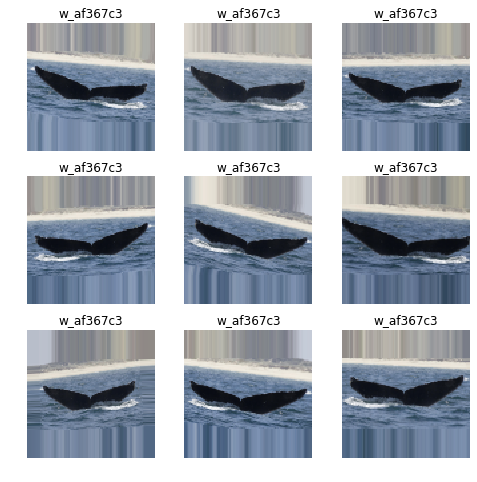

In [16]:
# Display examples of the transformation on a single image
def _plot(i,j,ax):
    x,y = data.train_ds[idx]
    x.show(ax,y=y)

idx = np.random.randint(len(data.train_ds))
plot_multi(_plot, 3, 3, figsize=(8,8))  ## show how the image is being transformed

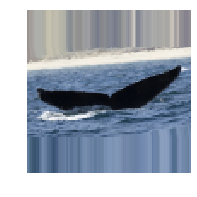

In [17]:
data.train_ds[idx][0].show() # orginal image

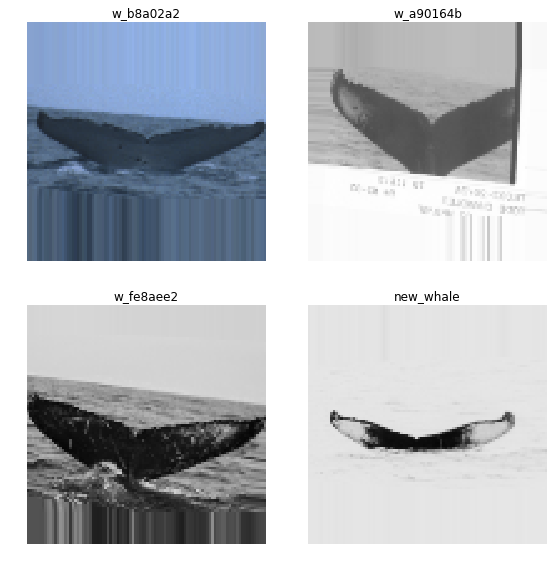

In [18]:
data.show_batch(rows=2, figsize=(8,8))  # this keeps crashing my computer

## Training

In [19]:
def mapr(input: torch.Tensor, targs: torch.LongTensor, mapn: int):
    "Compute the mean average precision"
    n = targs.shape[0]  # number for samples
    input = input.argsort(dim=-1, descending=True)[:,:mapn]
    targs = targs.view(n, -1)
    return ((input == targs).float()/torch.arange(1,mapn+1, device=input.device).float()).sum(dim=-1).mean()

map5 = partial(mapr, mapn=5)

In [20]:
learn = create_cnn(data=data, arch=models.resnet18, metrics=[accuracy, map5])

In [21]:
learn.fit_one_cycle(1, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,mapr
1,6.149260,6.213713,0.319269,0.328607


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


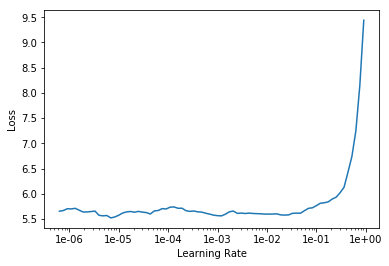

In [23]:
learn.recorder.plot()

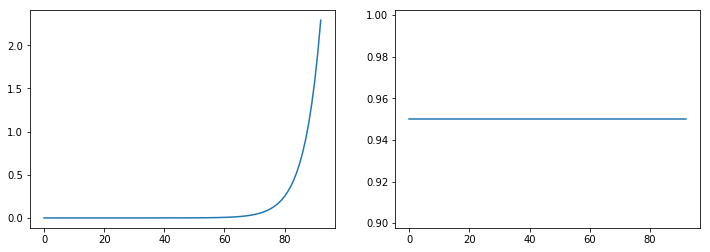

In [24]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

In [91]:
pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [92]:
pred.shape

torch.Size([7960, 5005])

In [93]:
pred_sort = pred.argsort(dim=-1, descending=True)[:,:5]
print(pred_sort.shape)
clsnp = np.asarray(learn.data.classes)
print(clsnp.shape)
pred_cls = [" ".join(clsnp[x]) for x in pred_sort.numpy()]
print(pred_cls[0])

torch.Size([7960, 5])
(5005,)
new_whale w_0a155b9 w_3de579a w_1834b49 w_c5260b8


In [94]:
test_df = pd.DataFrame({'Image': [fn.name for fn in learn.data.test_ds.items], 'Id': pred_cls})

In [95]:
test_df.head()

,Image,Id
0,00028a005.jpg,new_whale w_0a155b9 w_3de579a w_1834b49 w_c5260b8
1,000dcf7d8.jpg,new_whale w_343f088 w_a9304b9 w_88e4537 w_07768b0
2,000e7c7df.jpg,new_whale w_700ebb4 w_f0fe284 w_15951db w_343f088
3,0019c34f4.jpg,new_whale w_564a34b w_0fdf741 w_789c969 w_2365d55
4,001a4d292.jpg,new_whale w_9c506f6 w_3de579a w_23a388d w_0369a5c


In [88]:
test_df.head()

,Image,Id
0,00028a005.jpg,"new_whale,w_0a155b9,w_3de579a,w_1834b49,w_c5260b8"
1,000dcf7d8.jpg,"new_whale,w_343f088,w_a9304b9,w_88e4537,w_07768b0"
2,000e7c7df.jpg,"new_whale,w_700ebb4,w_f0fe284,w_15951db,w_343f088"
3,0019c34f4.jpg,"new_whale,w_564a34b,w_0fdf741,w_789c969,w_2365d55"
4,001a4d292.jpg,"new_whale,w_9c506f6,w_3de579a,w_23a388d,w_0369a5c"


In [96]:
test_df.shape

(7960, 2)

In [97]:
test_df.to_csv("./submission/sub_test.csv", index=False)

In [99]:
!kaggle competitions submit -c humpback-whale-identification -f "./submission/sub_test.csv" -m "sub_test"

Successfully submitted to Humpback Whale Identification



  0%|          | 0.00/505k [00:00<?, ?B/s]
 16%|#5        | 80.0k/505k [00:00<00:00, 775kB/s]
 36%|###6      | 184k/505k [00:00<00:00, 708kB/s] 
 59%|#####8    | 296k/505k [00:00<00:00, 759kB/s]
 78%|#######7  | 392k/505k [00:00<00:00, 804kB/s]
 90%|######### | 456k/505k [00:00<00:00, 536kB/s]
100%|##########| 505k/505k [00:03<00:00, 171kB/s]
